# Reading image files

In [3]:
import datetime
import glob
import os
import pathlib
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from PIL import Image
from sklearn.model_selection import train_test_split


In [4]:
with open('parameters.yaml') as yaml_data:
    params = yaml.safe_load(yaml_data)
    
TRAINING_CSV_PATH = params['paths']['training_images']
TEST_IMAGES_PATH = params['paths']['test_images']
TEST_GT = params['paths']['test_GT']
save_model_path = params['paths']['save_model_path']
load_model_path = params['paths']['load_model_path']

IMAGE_WIDTH = params['parameters']['IMAGE_WIDTH']
IMAGE_HEIGHT = params['parameters']['IMAGE_HEIGHT']



In [5]:
os.path.dirname(TRAINING_CSV_PATH)

'../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*'

In [6]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        images_list.append(image)
        
    return images_list


def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values


In [7]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
1,00000_00001.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
2,00000_00002.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
3,00000_00003.ppm,31,31,5,5,26,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
4,00000_00004.ppm,30,32,5,6,25,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


In [8]:
build_classes_array(images_df)

array([ 0,  0,  0, ..., 42, 42, 42], dtype=int64)

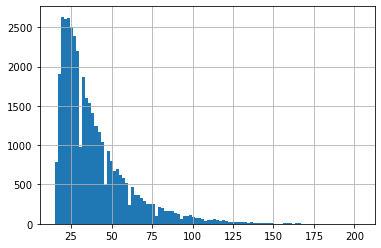

In [9]:
(images_df['Roi.X2'] - images_df['Roi.X1']).hist(bins=100);

In [10]:
(images_df['Roi.Y2'] - images_df['Roi.Y1']).median()

32.0

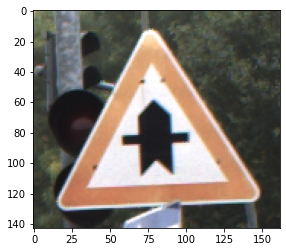

In [11]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]))

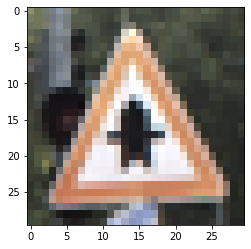

In [12]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]).resize((IMAGE_WIDTH, IMAGE_HEIGHT)))

# Building the learning database

In [13]:
images_df.shape

(39209, 9)

In [14]:
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
1,00000_00001.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
2,00000_00002.ppm,30,30,5,5,25,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
3,00000_00003.ppm,31,31,5,5,26,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...
4,00000_00004.ppm,30,32,5,6,25,26,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


In [15]:
N = None #N: number of image - Take all images if None

if N is None:
    images_list = build_images_list(images_df.head(N)['path'].values,
                                images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
    data = np.array(images_list)
    labels = build_classes_array(images_df)
    
else:
    images_list = build_images_list(images_df.head(N)['path'].values,
                                images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
    data = np.array(images_list)
    labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [16]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [17]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

# Training the model

In [36]:
# Compilation of the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0

In [37]:
#%%time
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/15
981/981 [==============================] - 139s 141ms/step - loss: 1.7615 - accuracy: 0.5729 - val_loss: 0.4371 - val_accuracy: 0.8975
Epoch 2/15
981/981 [==============================] - 133s 135ms/step - loss: 0.5736 - accuracy: 0.8429 - val_loss: 0.2027 - val_accuracy: 0.9449
Epoch 3/15
981/981 [==============================] - 131s 133ms/step - loss: 0.3814 - accuracy: 0.8952 - val_loss: 0.1813 - val_accuracy: 0.9546
Epoch 4/15
981/981 [==============================] - 149s 151ms/step - loss: 0.3112 - accuracy: 0.9143 - val_loss: 0.1073 - val_accuracy: 0.9736
Epoch 5/15
981/981 [==============================] - 161s 164ms/step - loss: 0.2760 - accuracy: 0.9238 - val_loss: 0.1136 - val_accuracy: 0.9719
Epoch 6/15
981/981 [==============================] - 144s 147ms/step - loss: 0.2468 - accuracy: 0.9311 - val_loss: 0.0742 - val_accuracy: 0.9814
Epoch 7/15
981/981 [==============================] - 158s 161ms/step - loss: 0.2169 - accuracy: 0.9394 - val_loss: 0.0690 -

In [40]:
# Save the model
def save_classifier(model, basename):
    """Save to H5 format a TF model with a timestamp
    
    Paramaters
    ----------
    model: trained tf model
    basename: basename including path to use for filename
    
    Returns
    -------
    None
    """
    model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
    return


# Saving - loading the model

In [47]:
save_classifier(model,save_model_path+"traffic_signs")

In [19]:
# Loading the model
model = tf.keras.models.load_model(load_model_path+'_2021-03-20_09-32-50.h5')

# Performance of the model

## Plotting graphs for accuracy

In [20]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

## Evaluating performance on the test set

### Classify images

In [21]:
def classify_image(path, model, image_box=None):
    """Classify image by model
    
    Parameters
    ----------
    path: filepath to image
    model: tf/keras classifier
    
    Returns
    -------
    class id returned by model classifier
    """
    images_list = []
    image = Image.open(path)
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
    image = np.array(image)
    images_list.append(image)
    
    return model.predict_classes(np.array(images_list))


In [22]:
image_sample = images_df.sample(1)

classify_image(image_sample['path'].values[0],
               model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([10], dtype=int64)

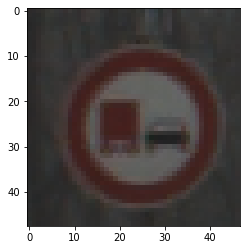

In [23]:
plt.imshow(Image.open(image_sample['path'].values[0]))

In [24]:
def proba_image(path, model, image_box=None):
    """Probabilities of traffic signs for an image by model
    
    Parameters
    ----------
    path: filepath to image
    model: tf/keras classifier
    
    Returns
    -------
    list of probabilities of each traffic signs
    """
    images_list = []
    image = Image.open(path)
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
    image = np.array(image)
    images_list.append(image)
    
    return model.predict(np.array(images_list)).tolist()[0]

In [25]:
proba_sample= proba_image(image_sample['path'].values[0],
               model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0])

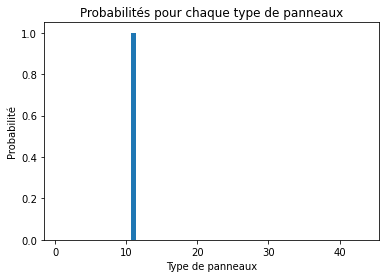

In [26]:
nb_class = np.arange(1,44)

plt.bar(nb_class, proba_sample, align='center')
plt.ylabel('Probabilité')
plt.xlabel('Type de panneaux')
plt.title('Probabilités pour chaque type de panneaux')

plt.show()

### Load test images

In [28]:
test_images_df = pd.read_csv(TEST_GT, sep=';')
test_images_df['path'] = test_images_df['Filename'].apply(lambda x: TEST_IMAGES_PATH + x)
test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12626,12626.ppm,50,51,6,5,45,46,33,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12627,12627.ppm,29,29,6,6,24,24,6,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12628,12628.ppm,48,49,5,6,43,44,7,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...
12629,12629.ppm,32,31,6,5,27,26,10,../data/raw/GTSRB_Final_Test_Images/GTSRB/Fina...


In [64]:
test_list = build_images_list(test_images_df['path'].values,
                                test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)

In [65]:
#%%time
results = test_model.predict_classes(test_data)

In [66]:
(test_labels == results).sum() / test_labels.shape[0]

0.9557403008709422

### Compare actual to predicted (class level)

In [67]:
np.transpose(results)

array([16,  1, 38, ..., 42,  7, 10], dtype=int64)

In [68]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results

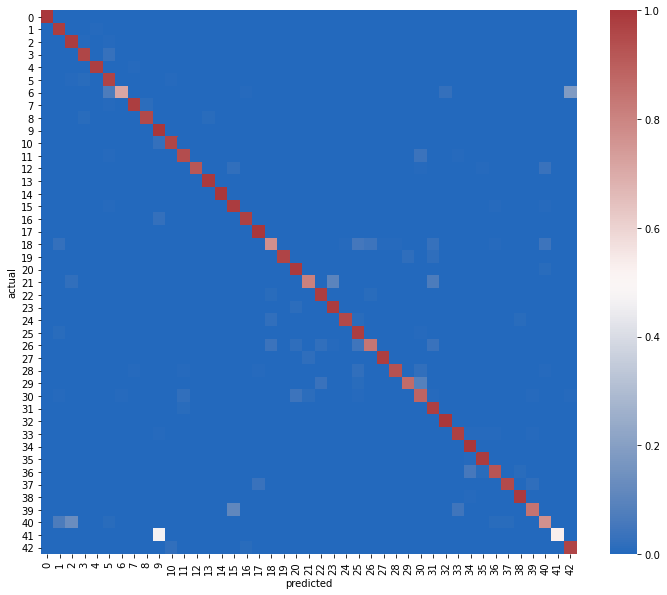

In [69]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'), cmap='vlag');